<a href="https://colab.research.google.com/github/MateusMaruzka/LM_InlineAssembly/blob/main/calib_lowcostsensors_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando as dependências:


1.   Tensorflow Decision Forests



In [1]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.2 MB 513 kB/s 
     |████████████████████████████████| 588.3 MB 5.7 kB/s 
     |████████████████████████████████| 6.0 MB 42.6 MB/s 
     |████████████████████████████████| 1.7 MB 40.9 MB/s 
     |████████████████████████████████| 439 kB 54.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [73]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold
from sys import version
print("running: ", version)

running:  3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]


In [3]:
df = pd.read_csv('sample_data/dataset.csv')
df.set_index('Date/Time', inplace = True)
df.dropna(inplace=True)

### Tukey's rule for outliers (IQR rule)

1. IQR =  Q3 - Q1
2. upper limit = Q3 + 1.5*IQR
3. lower limit = Q1 - 1.5*IQR

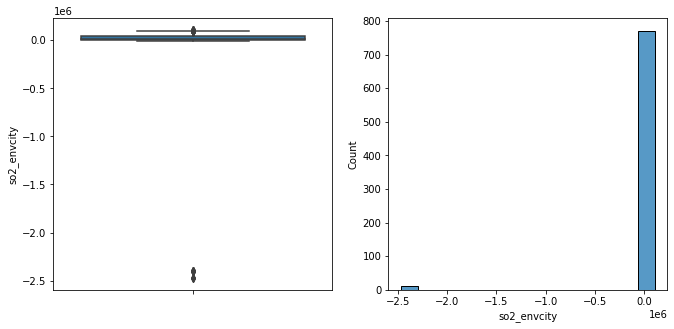

count    7.810000e+02
mean    -6.974144e+03
std      2.905356e+05
min     -2.468318e+06
25%      7.180826e+02
50%      1.090309e+04
75%      4.023740e+04
max      1.031252e+05
Name: so2_envcity, dtype: float64

In [33]:
l = 'so2_envcity'
def boxplot_histplot(data):
  fig, ax = plt.subplots(1, 2, figsize = (11,5))
  sns.boxplot(y = data, ax = ax[0])
  sns.histplot(data, ax = ax[1], bins = 15)
  plt.show()

boxplot_histplot(df[l])
df[l].describe()

In [34]:
Q1 = df[l].quantile(0.25)
Q3 = df[l].quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5*IQR
upper_lim = Q3 + 1.5*IQR
print(f'First quantile = {Q1}')
print(f'Third quantile = {Q3}')
print(f'IQR = {IQR}')
print(f'Lower limit = {lower_lim}')
print(f'upper limit = {upper_lim}')

First quantile = 718.0826065879995
Third quantile = 40237.396473630106
IQR = 39519.3138670421
Lower limit = -58560.88819397515
upper limit = 99516.36727419327


In [36]:
outliers = (df[l] < lower_lim) | (df[l] > upper_lim)
print(len(df[l][outliers]))
print(f'Outliers -> {len(df[l][outliers])*100 / len(df[l])} %')

44
Outliers -> 5.633802816901408 %


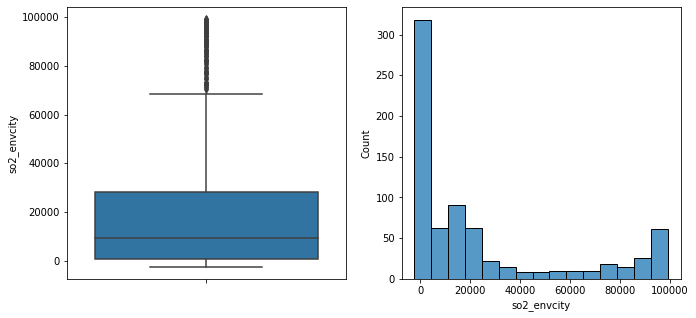

In [37]:
#  Dropping outliers
boxplot_histplot(df[l][~outliers])

In [ ]:
# Modifying outliers by winsorize method
from scipy.stats.mstats import winsorize

df_winsorize = winsorize(df[l], (0.01, 0.02))

boxplot_histplot(df_winsorize)

In [ ]:
# Log transformation: reduces the skewness of data and tries to make it normal

df_log = np.log(df[l])
boxplot_histplot(df_log)

84
Outliers:  co
84
Outliers -> 10.755441741357235 %


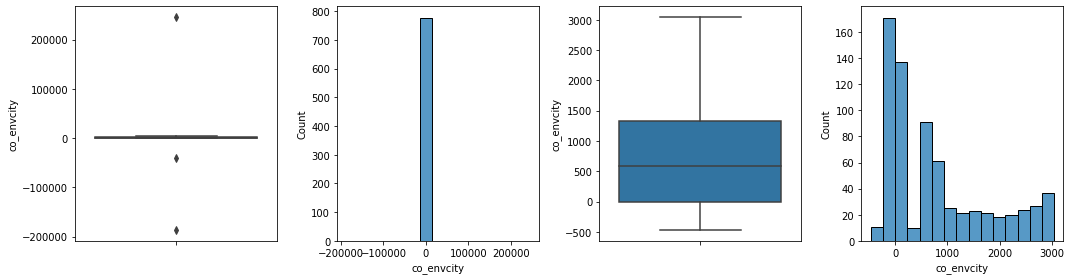

41
Outliers:  h2s
41
Outliers -> 5.249679897567222 %


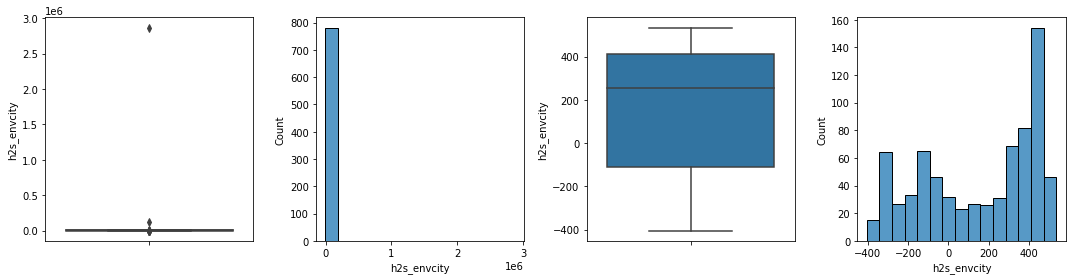

149
Outliers:  no2
149
Outliers -> 19.07810499359795 %


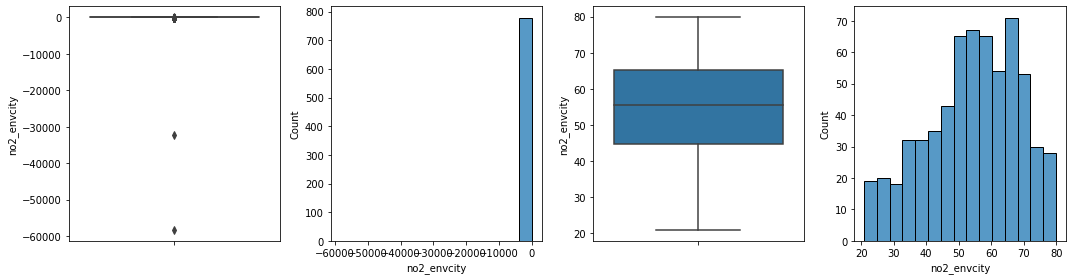

182
Outliers:  so2
182
Outliers -> 23.303457106274006 %


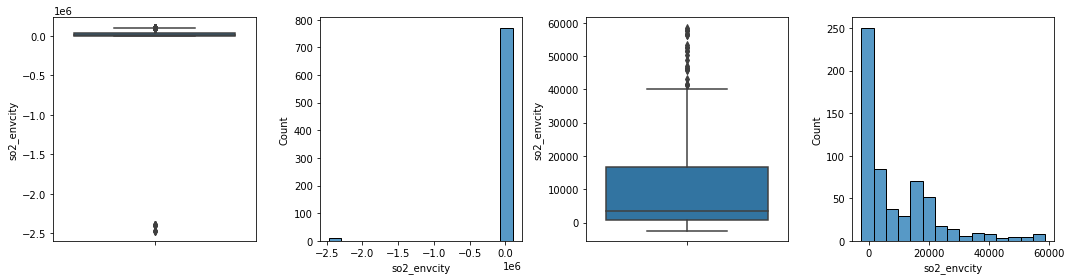

139
Outliers:  nh3
139
Outliers -> 17.797695262483995 %


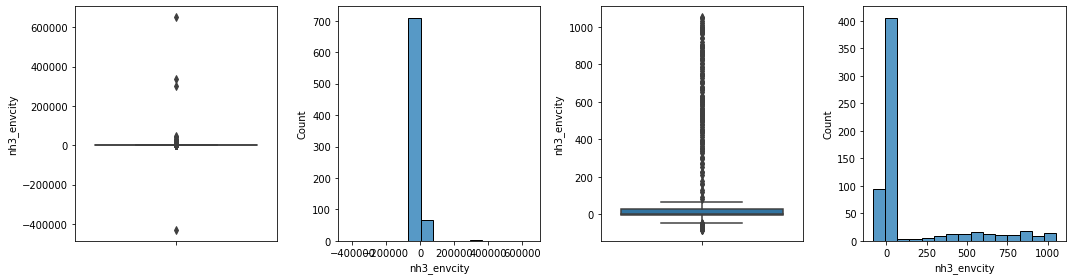

84
Outliers:  o3
84
Outliers -> 10.755441741357235 %


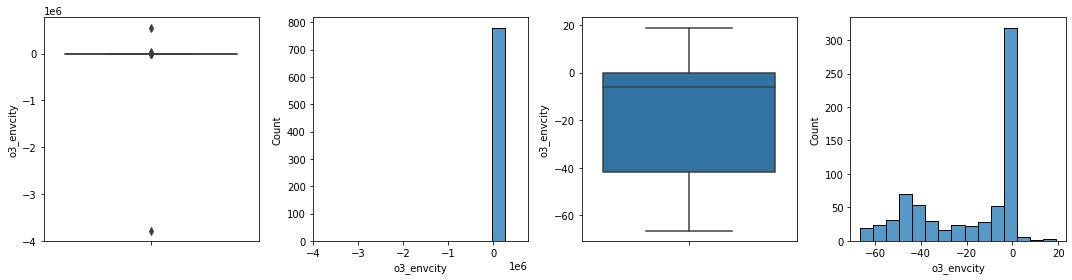

{'co': 10.755441741357235, 'h2s': 5.249679897567222, 'no2': 19.07810499359795, 'so2': 23.303457106274006, 'nh3': 17.797695262483995, 'o3': 10.755441741357235}


In [71]:
def quantiles(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_lim = Q1 - 0.5*IQR
  upper_lim = Q3 + 0.5*IQR
  return Q1, Q3, lower_lim, upper_lim, IQR

def outliers_df(df, method = 'drop'): 
  """
  Gera um boxplot pra cada variável no df em relação a referência
  method: 'drop', 'winsorize' e 'log'
  """
  label = ['co', 'h2s', 'no2', 'so2', 'nh3', 'o3']
  res = {}
  for l in label:

    data = df[l + '_envcity']
    
    Q1, Q3, low, up, IQR = quantiles(data)
    outliers = (data < low) | (data > up)
    print(np.sum(outliers))
    print('Outliers: ', l)
    print(len(data[outliers]))
    outliers_num = len(data[outliers])*100 / len(data)
    print(f'Outliers -> {outliers_num} %')

    res[l] =  outliers_num

    fig, ax = plt.subplots(1, 4, figsize = (15,4))

    sns.boxplot(y = data, ax = ax[0], whis=1.5)
    # ax[0].boxplot(data)
    sns.histplot(data, ax = ax[1], bins = 15)

    if method == 'drop':
      sns.boxplot(y = data[~outliers], ax = ax[2],  whis=1.5)
      # ax[0].boxplot(data[~outliers])
      sns.histplot(data[~outliers], ax = ax[3], bins = 15)
    elif method = :

    plt.tight_layout()
    plt.show()

  return res

print(outliers_df(df))
# df.describe()

In [ ]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


In [ ]:
label = 'co_iat'
label_envcity = 'co_envcity'
Yco = df[label]
Xco = df.loc[Yco.index][[label,'temperatura_envcity','umidade_envcity', label_envcity]]

train_ds_pd, test_ds_pd = split_dataset(Xco)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)


In [ ]:
# Train a Random Forest model.
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
# model.fit(x=X_train, y=y_train)
model.fit(train_ds)

In [ ]:
# Summary of the model structure.
model.summary()

In [ ]:
# Evaluate the model.
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

# Export the model to a SavedModel.
# model.save("project/model")

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)